# Sample source code for 'Seven proofs of the Pearson Chi-squared independence test and its graphical interpretation'

We provide below the source code and examples that are included in the paper 'Seven proofs of the Pearson Chi-squared independence test and its graphical interpretation' by Eric Benhamou and Valentin Melot

The main idea is to add to a standard mosaic plot a confindence interval to visualize how close or far we
are from accepting or rejecting the null hypothesis of non independence.

For more details about the mathematical foundation, please refer to arxiv.org paper

In [1]:
# general imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as scs

In [2]:
""" 
mosaic plot function to display a 2 x2 contingency table and a confidence interval
df should be a double-index for rows
e.g.
    Index_1          Index_2         Value                       
    AA               C               30
                     P               40
    BB               C               50
                     P               60
order: how columns are order, by default, from the biggest to the smallest in term of category. Possible values are 
    - "Size" [default]
    - "Normal" : as the columns are order in the input df
    - list of column names to reorder the column
    
color_dictionary: should be a dictionary of color with key corresponding to (row_name,col_name)
    if not provided used default color
    

return fig, ax
"""

def mosaic_plot(df, color_dictionary=None, row_labels=None, col_labels=None, top_label=None,
                x_label=None, y_label=None, pad_x=0.01, pad_y=0.01, ax=None, order="Size",
                figsize=None, category=None, quantile=0.99, print_calculation=True):

    if ax == None:
        if figsize == None:
            figsize = (len(df.columns), len(df.index.get_level_values(0).unique()))
        fig, ax = plt.subplots(1,1, figsize=figsize)

    size_col = df.sum().sort_values(ascending=False)
    prop_com = size_col.div(size_col.sum())

    if quantile < 1 and quantile > 0.5:
        N = np.sum(df.values)
        phat = np.sum(df.values[0,:]) / N
        deltap = scs.norm.ppf(quantile) * np.sqrt(phat * (1-phat) / N)
        if print_calculation:
            print('Calculation')
            print('N     =',N)
            print('phat  =',phat)
            print('deltap=',deltap)
            print(' ')
            print('Data')
            print(df)
            print(' ')

    if order == "Size":
        df = df[size_col.index.values]
    elif order == "Normal":
        prop_com = prop_com[df.columns]
        size_col = size_col[df.columns]

    default_colors = [
            (0.65 ,  0.375,  0.375), #red light
            (0.5 ,  0.25,  0.25),    #red dark
            (0.25,  0.5 ,  0.25),    #green light
            (0.125,  0.5  ,  0.125 ),#green dark
    ]

    if color_dictionary == None:
        color_dictionary = {}
    
    x = 0    
    for i0, j in enumerate(df.groupby(level=0).sum().iteritems()):
        bot = 0
        S = float(j[1].sum())
        j0 = 0
        for lab, k in j[1].iteritems():
            key = (df.axes[0][i0], df.axes[1][j0])
            if key not in color_dictionary:
                color_dictionary[key] = default_colors[2*i0+j0]
            ax.bar(x, k/S, width=prop_com[j[0]], bottom=bot, color=color_dictionary[key], lw=0, align="edge")
            bot += k/S + pad_y
            j0 += 1
        x += prop_com[j[0]] + pad_x
        i0 += 1

    ## Aesthetic of the plot and ticks
    # Y-axis
    true_y_labels = df.index
    Yt = (df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())+pad_y).cumsum() - pad_y
    Ytt = df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())
    
    if row_labels == None:
        row_labels = Yt.index
    ax.set_yticks(Yt - Ytt/2)
    ax.set_yticklabels(row_labels)

    ax.set_ylim(0, 1 + (len(j[1]) - 1) * pad_y)
    if y_label == None:
        y_label = df.index.names[0]
        if y_label == None:
            y_label = "Y-axis"
    ax.set_ylabel(y_label)

    # X-axis
    if col_labels == None:
        col_labels = prop_com.index
    xticks = (prop_com + pad_x).cumsum() - pad_x - prop_com/2.
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_labels)
    ax.set_xlim(0, prop_com.sum() + pad_x * (len(prop_com)-1))

    if x_label == None:
        x_label = df.columns.name
        if x_label == None:
            x_label = "X-axis"
    ax.set_xlabel(x_label)

    # Top label
    if top_label == None:
        test = scs.chi2_contingency(df)
        top_label = "Mosaic Plot (Pearson p-value={:0.4g})".format(test[1])
        
    if top_label:
        ax2 = ax.twiny()
        ax2.set_xlim(*ax.get_xlim())
        ax2.set_xticks(xticks) 
        ax2.set_xticklabels(size_col.values.astype(int))
        ax2.set_xlabel(top_label)
        ax2.tick_params(top=False, right=False, pad=0, length=0)

    # Ticks and axis settings

    ax.tick_params(top=False, right=False, pad=5)
    sns.despine(left=0, bottom=False, right=0, top=0, offset=3)

    # Legend
    plt.tight_layout(rect=[0, 0, .9, 0.95])
    
    # confidence interval
    if quantile < 1 and quantile > 0.5:
        lines=[(phat+deltap, "w--", {"linewidth": 2}),
               (phat-deltap, "w--", {"linewidth": 2})]
        for y, form, param in lines:
            plt.plot([0, 1], [y, y], form, **param)
    return fig, ax

Calculation
N     = 200
phat  = 0.5
deltap= 0.0822488178567
 
Data
    C   D
A  50  50
B  50  50
 


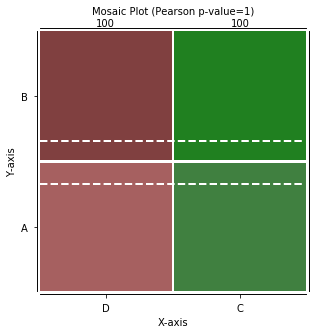

In [3]:
#creation of a dataframe
initial_data = np.array([[50, 50], [50, 50]])
df = pd.DataFrame(initial_data, index = ['A', 'B'], columns = ['C', 'D'])
fig, ax = mosaic_plot(df, figsize=(5,5))
fig.savefig('figures/initial_figure.png')

Calculation
N     = 225
phat  = 0.555555555556
deltap= 0.077064770158
 
Data
    C   D
A  75  50
B  50  50
 


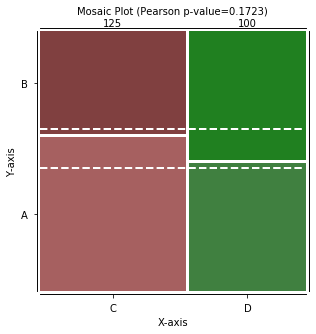

Calculation
N     = 225
phat  = 0.555555555556
deltap= 0.077064770158
 
Data
    C   D
A  50  75
B  50  50
 


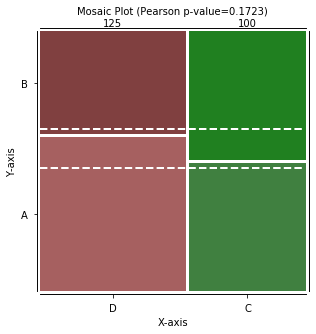

Calculation
N     = 225
phat  = 0.444444444444
deltap= 0.077064770158
 
Data
    C   D
A  50  50
B  75  50
 


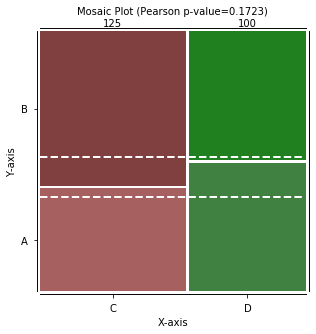

Calculation
N     = 225
phat  = 0.444444444444
deltap= 0.077064770158
 
Data
    C   D
A  50  50
B  50  75
 


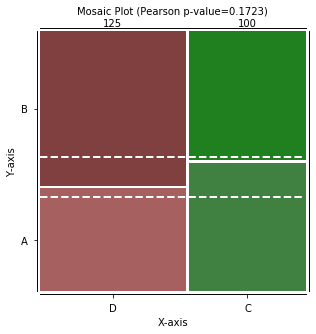

Calculation
N     = 250
phat  = 0.6
deltap= 0.0720792525892
 
Data
     C   D
A  100  50
B   50  50
 


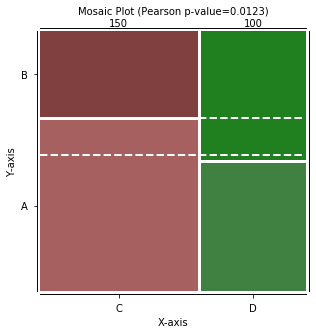

Calculation
N     = 250
phat  = 0.6
deltap= 0.0720792525892
 
Data
    C    D
A  50  100
B  50   50
 


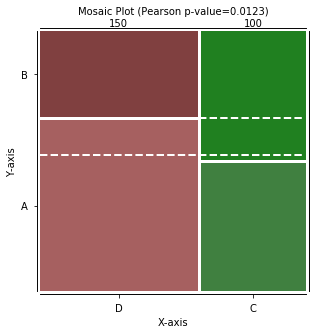

Calculation
N     = 250
phat  = 0.4
deltap= 0.0720792525892
 
Data
     C   D
A   50  50
B  100  50
 


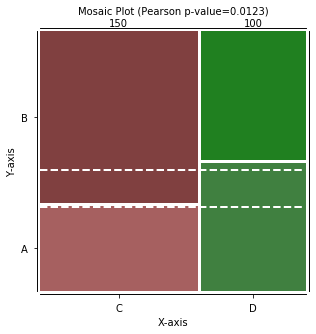

Calculation
N     = 250
phat  = 0.4
deltap= 0.0720792525892
 
Data
    C    D
A  50   50
B  50  100
 


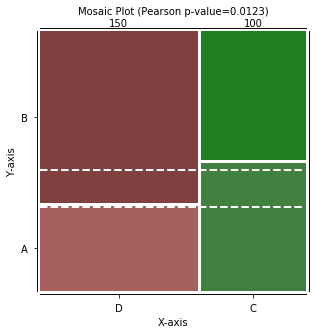

Calculation
N     = 350
phat  = 0.714285714286
deltap= 0.0561749372493
 
Data
     C   D
A  200  50
B   50  50
 


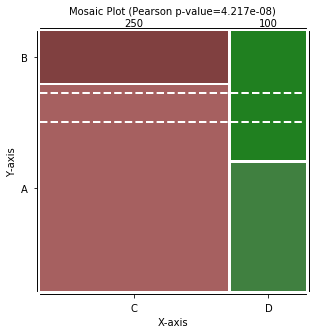

Calculation
N     = 350
phat  = 0.714285714286
deltap= 0.0561749372493
 
Data
    C    D
A  50  200
B  50   50
 


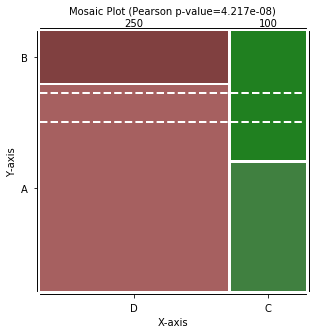

Calculation
N     = 350
phat  = 0.285714285714
deltap= 0.0561749372493
 
Data
     C   D
A   50  50
B  200  50
 


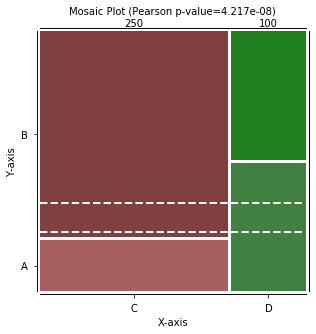

Calculation
N     = 350
phat  = 0.285714285714
deltap= 0.0561749372493
 
Data
    C    D
A  50   50
B  50  200
 


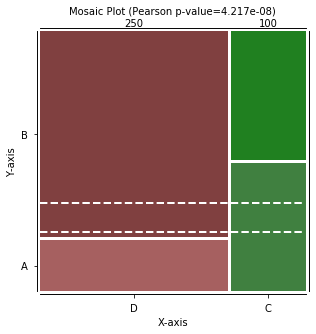

In [4]:
# replace any value by 100 and plot
change_values = [75, 100, 200]

for change_value in change_values:
    for i in range(2):
        for j in range(2):
            data = initial_data.copy()
            data[i,j] = change_value
            df = pd.DataFrame(data, index = ['A', 'B'], columns = ['C', 'D'])
            fig, ax = mosaic_plot(df, figsize=(5,5))
            fig.savefig('figures/mosaic-{0}-{1}.png'.format(change_value, i*2+j+1))
            plt.show()